# Imports

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2

from os.path import join
from os import listdir
import torch.nn as nn
import torch
from torchvision.models import vgg19
import os
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from skimage.metrics import structural_similarity as calc_ssim
from skimage.metrics import peak_signal_noise_ratio as calc_psnr
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/hobbit132480/Images.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Images/5499.png  
  inflating: /content/Images/55.png  
  inflating: /content/Images/550.png  
  inflating: /content/Images/5500.png  
  inflating: /content/Images/5501.png  
  inflating: /content/Images/5502.png  
  inflating: /content/Images/5503.png  
  inflating: /content/Images/5504.png  
  inflating: /content/Images/5505.png  
  inflating: /content/Images/5506.png  
  inflating: /content/Images/5507.png  
  inflating: /content/Images/5508.png  
  inflating: /content/Images/5509.png  
  inflating: /content/Images/551.png  
  inflating: /content/Images/5510.png  
  inflating: /content/Images/5511.png  
  inflating: /content/Images/5512.png  
  inflating: /content/Images/5513.png  
  inflating: /content/Images/5514.png  
  inflating: /content/Images/5515.png  
  inflating: /content/Images/5516.png  
  inflating: /content/Images/5517.png  
  inflating: /content/Images/5518.png  
  inflating: /co

In [ ]:
!unzip /content/drive/Shareddrives/hobbit132480/Images256.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Images256/5499.png  
  inflating: /content/Images256/55.png  
  inflating: /content/Images256/550.png  
  inflating: /content/Images256/5500.png  
  inflating: /content/Images256/5501.png  
  inflating: /content/Images256/5502.png  
  inflating: /content/Images256/5503.png  
  inflating: /content/Images256/5504.png  
  inflating: /content/Images256/5505.png  
  inflating: /content/Images256/5506.png  
  inflating: /content/Images256/5507.png  
  inflating: /content/Images256/5508.png  
  inflating: /content/Images256/5509.png  
  inflating: /content/Images256/551.png  
  inflating: /content/Images256/5510.png  
  inflating: /content/Images256/5511.png  
  inflating: /content/Images256/5512.png  
  inflating: /content/Images256/5513.png  
  inflating: /content/Images256/5514.png  
  inflating: /content/Images256/5515.png  
  inflating: /content/Images256/5516.png  
  inflating: /content/Images256/5

# Model Training

In [ ]:
def gauss_noise(image):
    row,col= image.shape
    mean = 0.0
    var = 0.005
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    noisy = np.clip(noisy, -1.0, 1.0)
    return noisy.astype(np.float32)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, dirs, size):
        super(TrainDataset, self).__init__()
        self.dirs = dirs
        self.scale = 4
        self.size = size


    @staticmethod
    def random_horizontal_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[:, ::-1].copy()
            hr = hr[:, ::-1].copy()
        return lr, hr

    @staticmethod
    def random_vertical_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[::-1, :].copy()
            hr = hr[::-1, :].copy()
        return lr, hr


    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 127.5 - 1.
        lr = gauss_noise(np.array(hr))
        #lr = hr
        lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        lr, hr = self.random_horizontal_flip(lr, hr)
        lr, hr = self.random_vertical_flip(lr, hr)
        lr = np.expand_dims(lr, 0).astype(np.float32)
        hr = np.expand_dims(hr, 0).astype(np.float32)
        return lr, hr

    def __len__(self):
        return len(self.dirs)


class EvalDataset(Dataset):
    def __init__(self, dirs, size):
        super(EvalDataset, self).__init__()
        self.dirs = dirs
        self.scale = 4
        self.size = size

    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 127.5 - 1.
        lr = gauss_noise(np.array(hr))
        #lr = hr
        lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        return np.expand_dims(lr, 0), np.expand_dims(hr, 0)

    def __len__(self):
        return len(self.dirs)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(weights='VGG19_Weights.DEFAULT')
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

epoch: 10/10: 100%|█████████████████████████████| 10000/10000 [15:02<00:00, 11.08it/s, D_loss=0.001140, G_loss=0.279334]


22.305594769324504
0.6740379459682552


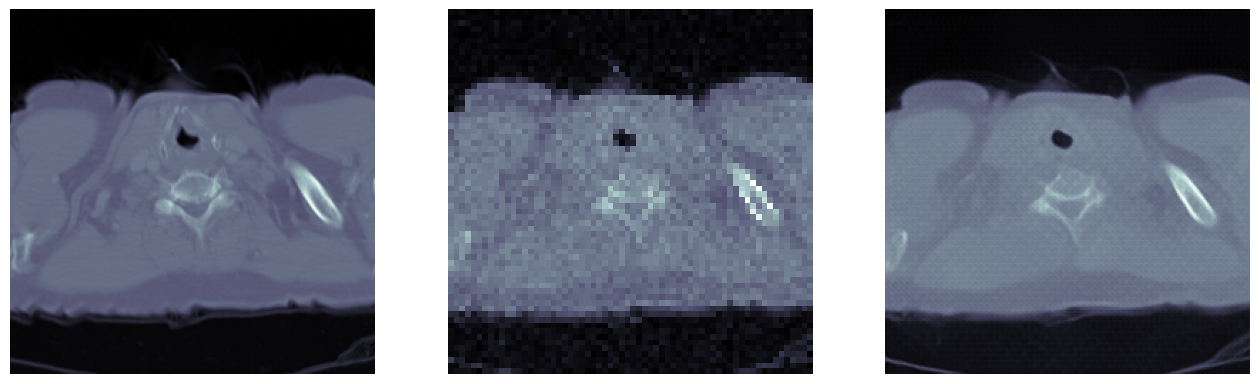

24.69490968917924
0.8074474537969306


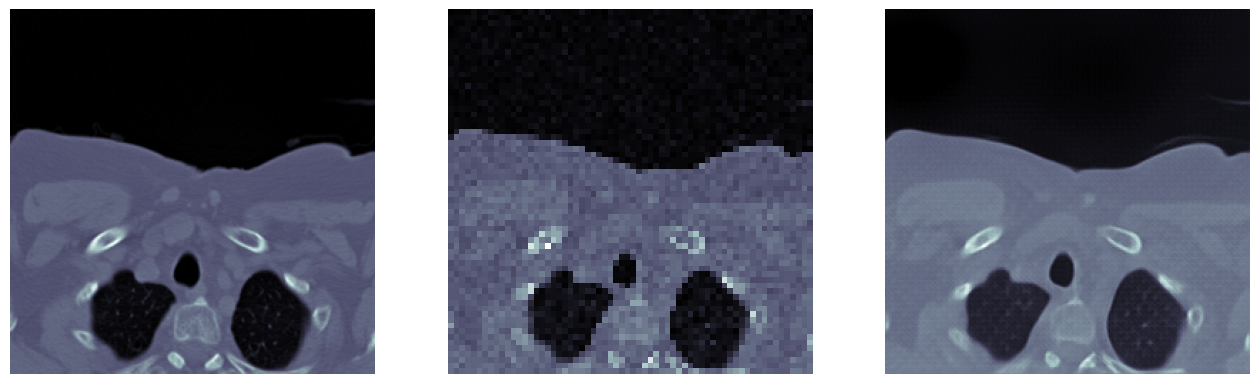

32.6039367507505
0.9265984769153595


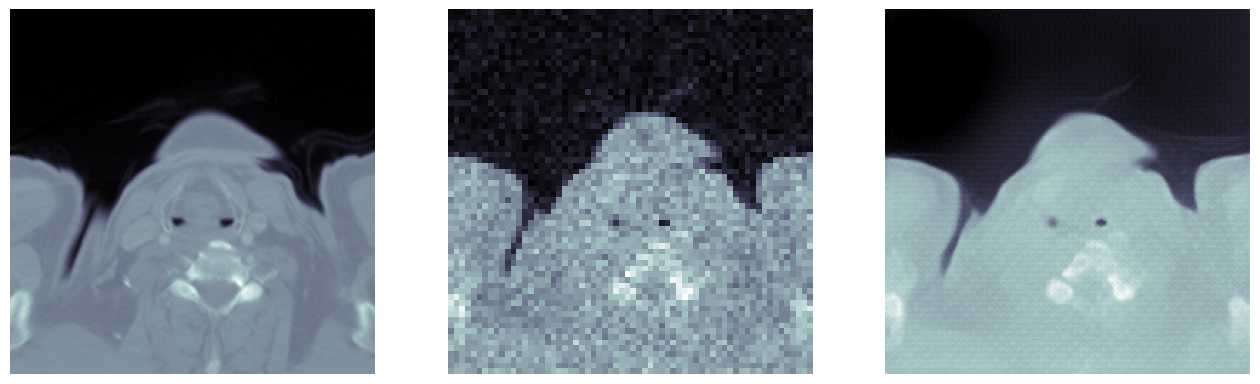

24.337190721699002
0.6180340721321236


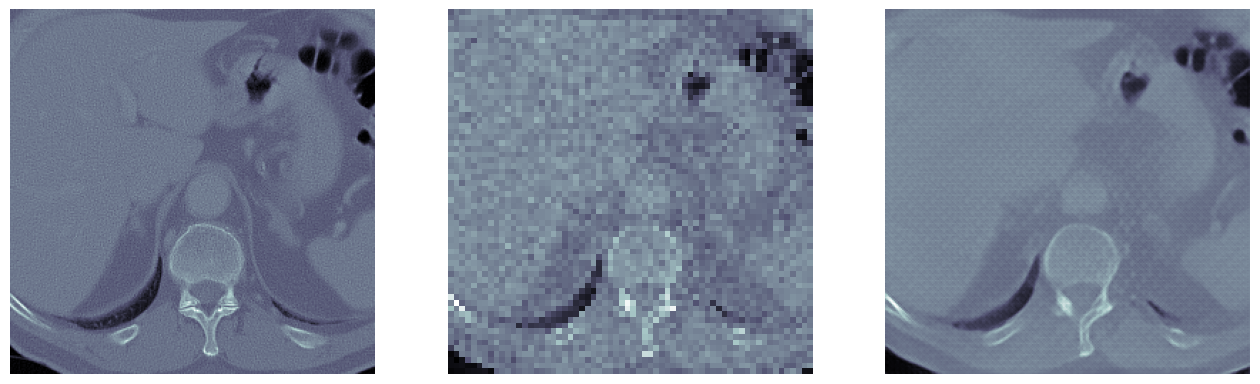

27.696584696024694
0.908480325975264


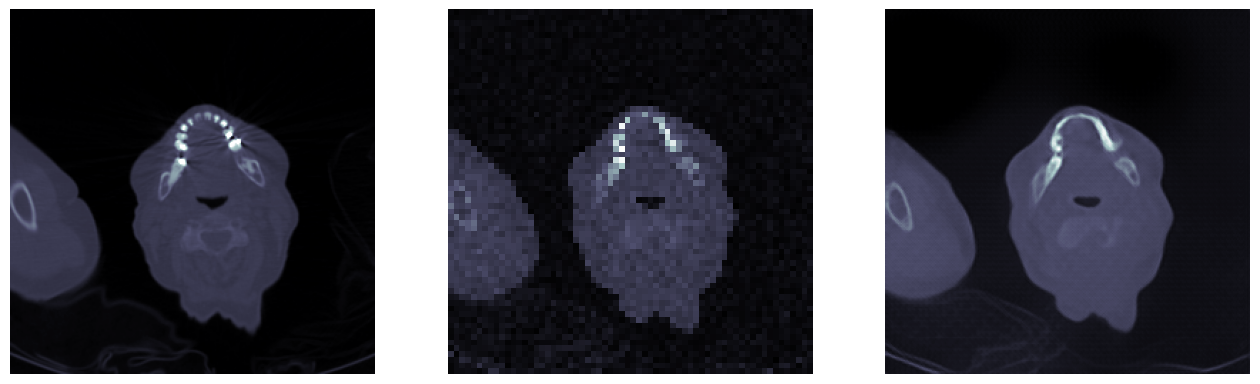

20.685659324213155
0.44894943561970235


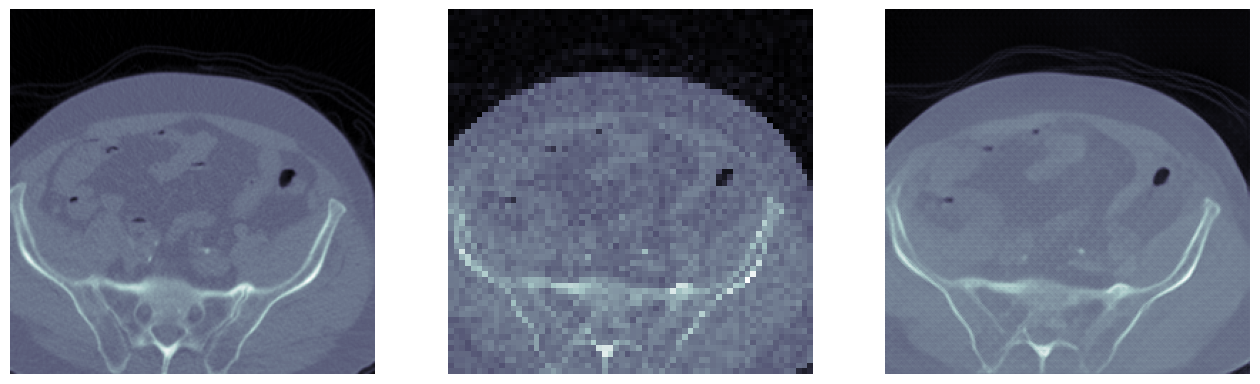

27.182205966062124
0.8045656488202736


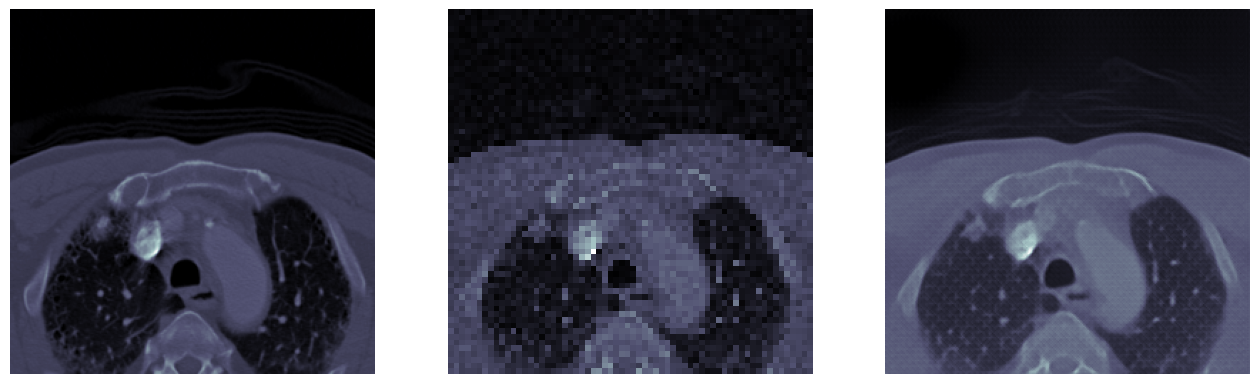

20.695401414506524
0.4125143853868952


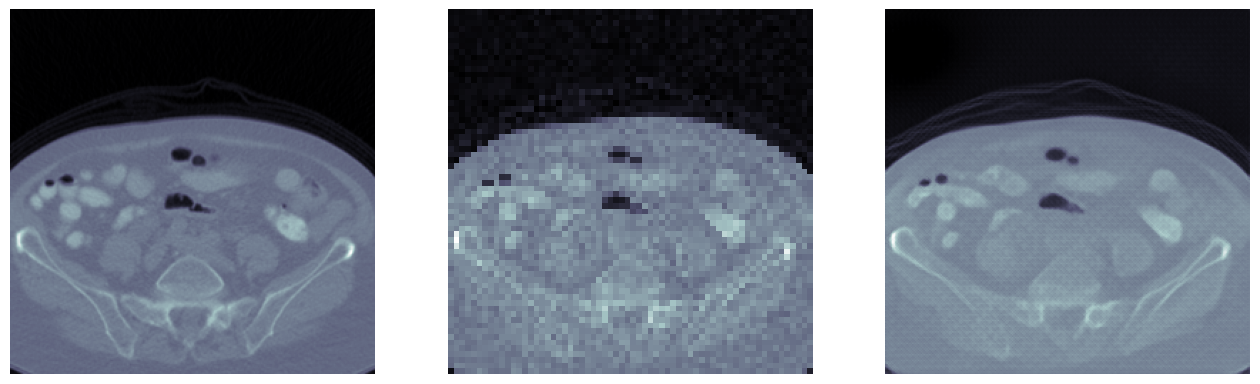

22.557067691659856
0.6647010888305434


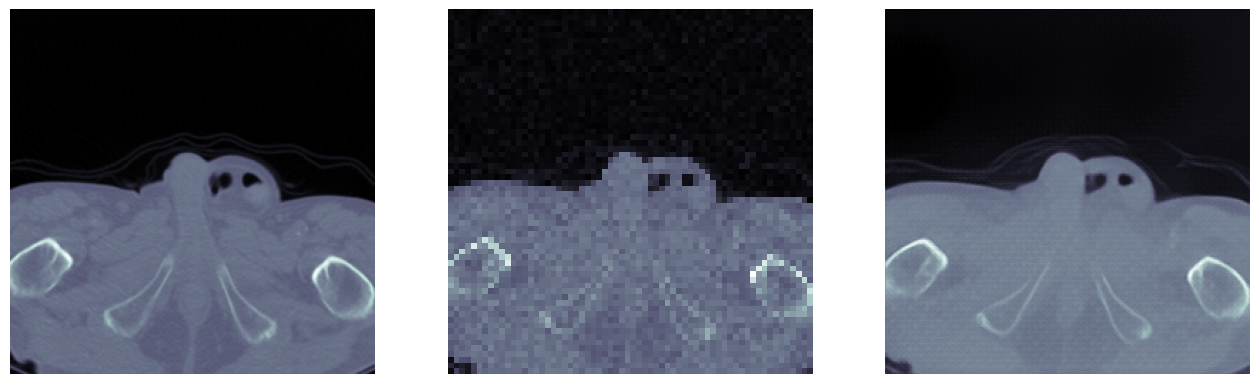

21.382014195794735
0.5915219761389843


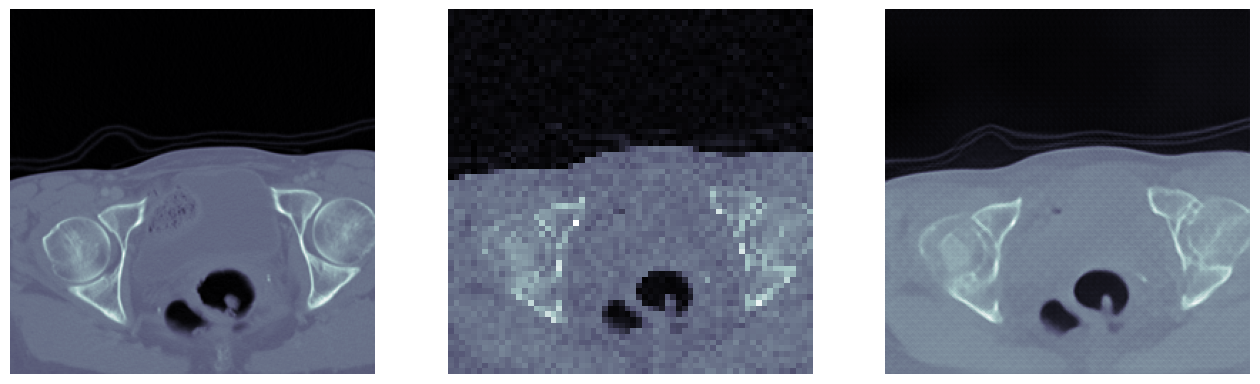

In [ ]:
s_epoch = 9
n_epochs = 10
batch_size = 4
lr = 0.0002
b1 = 0.5
b2 = 0.999
img_shape = (1, 256, 256)
num_workers = 0
data_file = 'Images256'
os.makedirs('SRGANOutput', exist_ok=True)
content_file = '/content/Examples'
os.makedirs(content_file, exist_ok=True)

images = [join(data_file, dir) for dir in listdir(data_file)]
images.sort()

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=img_shape)
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)
feature_extractor = feature_extractor.to(device)
criterion_GAN = criterion_GAN.to(device)
criterion_content = criterion_content.to(device)

if s_epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load(f"generator_{s_epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"discriminator_{s_epoch}.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

dataset = TrainDataset(images[:10000], 256)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
eval_dataset = EvalDataset(images[-3050:-3040], 256)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1, num_workers=num_workers)

# ----------
#  Training
# ----------
batch_G_losses = []
batch_D_losses = []
eval_psnr_byepoch = []
eval_ssim_byepoch = []

for epoch in range(s_epoch, n_epochs):
    generator.train()
    with tqdm(total=(len(dataset) - len(dataset) % batch_size), ncols=120) as t:
        t.set_description('epoch: {}/{}'.format(epoch + 1, n_epochs))
        for i, imgs in enumerate(dataloader):

            # Configure model input
            imgs_lr = imgs[0].to(device)
            imgs_hr = imgs[1].to(device)

            # Adversarial ground truths
            valid = torch.from_numpy(np.ones((imgs_lr.size(0), *discriminator.output_shape))).to(device).type(torch.float).detach()
            fake = torch.from_numpy(np.zeros((imgs_lr.size(0), *discriminator.output_shape))).to(device).type(torch.float).detach()

            # ------------------
            #  Train Generators
            # ------------------

            optimizer_G.zero_grad()

            # Generate a high resolution image from low resolution input
            gen_hr = generator(imgs_lr)


            # Adversarial loss
            loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

            # Content loss
            gen_features = feature_extractor(gen_hr.repeat(1, 3, 1, 1))
            real_features = feature_extractor(imgs_hr.repeat(1, 3, 1, 1))
            loss_content = criterion_content(gen_features, real_features.detach())

            # Total loss
            loss_G = loss_content + 1e-3 * loss_GAN

            loss_G.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss of real and fake images
            loss_real = criterion_GAN(discriminator(imgs_hr), valid)
            loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

            # Total loss
            loss_D = (loss_real + loss_fake) / 2

            loss_D.backward()
            optimizer_D.step()

            batch_G_losses.append(loss_G.item())
            batch_D_losses.append(loss_D.item())
            t.set_postfix({"D_loss": '{:.6f}'.format(loss_D.item()),
                           "G_loss": '{:.6f}'.format(loss_G.item()),
                           })
            t.update(len(imgs_lr))

    if epoch % 1 == 0:
        torch.save(generator.state_dict(), "SRGANOutput/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "SRGANOutput/discriminator_%d.pth" % epoch)
        generator.eval()
        for imgs in eval_dataloader:
            imgs_lr = imgs[0].to(device)
            imgs_hr = imgs[1].to(device)

            with torch.no_grad():
                gen_hr = generator(imgs_lr)

            gen_hr = gen_hr.cpu().numpy().squeeze(0).squeeze(0)
            imgs_hr = imgs_hr.cpu().numpy().squeeze(0).squeeze(0)
            imgs_lr = imgs_lr.cpu().numpy().squeeze(0).squeeze(0)
            p += calc_psnr(gen_hr, imgs_hr, data_range=2)
            s += calc_ssim(gen_hr, imgs_hr, data_range=2)
        l = len(eval_dataloader)
        print(p / l)
        print(s / l)
        eval_psnr_byepoch.append(p / l)
        eval_ssim_byepoch.append(s / l)
        fig, axess = plt.subplots(nrows=1, ncols=3)
        fig.set_size_inches(16, 8)
        axess[0].imshow(imgs_hr, plt.cm.bone)
        axess[0].set_axis_off()
        axess[1].imshow(imgs_lr, plt.cm.bone)
        axess[1].set_axis_off()
        axess[2].imshow(gen_hr, plt.cm.bone)
        axess[2].set_axis_off()
        plt.savefig(join(content_file, f'example{epoch}.png'), facecolor='white', bbox_inches='tight')
        plt.show()


# Results

In [ ]:
generator = GeneratorResNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
s_epoch = 9
if s_epoch != 0:
    generator.load_state_dict(torch.load(f"generator_{s_epoch}.pth"))

In [ ]:
images = [join('Images', dir) for dir in listdir('Images')]
images.sort()
val_dataset = EvalDataset(images[-3000:], 512)
dataloader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0)

generator.eval()
psnr = 0
ssim = 0

for imgs in dataloader:
    imgs_lr = imgs[0].to(device)
    imgs_hr = imgs[1].to(device)

    with torch.no_grad():
        gen_hr = generator(imgs_lr)

    gen_hr = gen_hr.cpu().numpy().squeeze(0).squeeze(0)
    imgs_hr = imgs_hr.cpu().numpy().squeeze(0).squeeze(0)
    imgs_lr = imgs_lr.cpu().numpy().squeeze(0).squeeze(0)
    psnr += calc_psnr(gen_hr, imgs_hr, data_range=2)
    ssim += calc_ssim(gen_hr, imgs_hr, data_range=2)

l = len(val_dataset)
psnr /= l
ssim /= l

26.375530794734797
0.8204013053522569


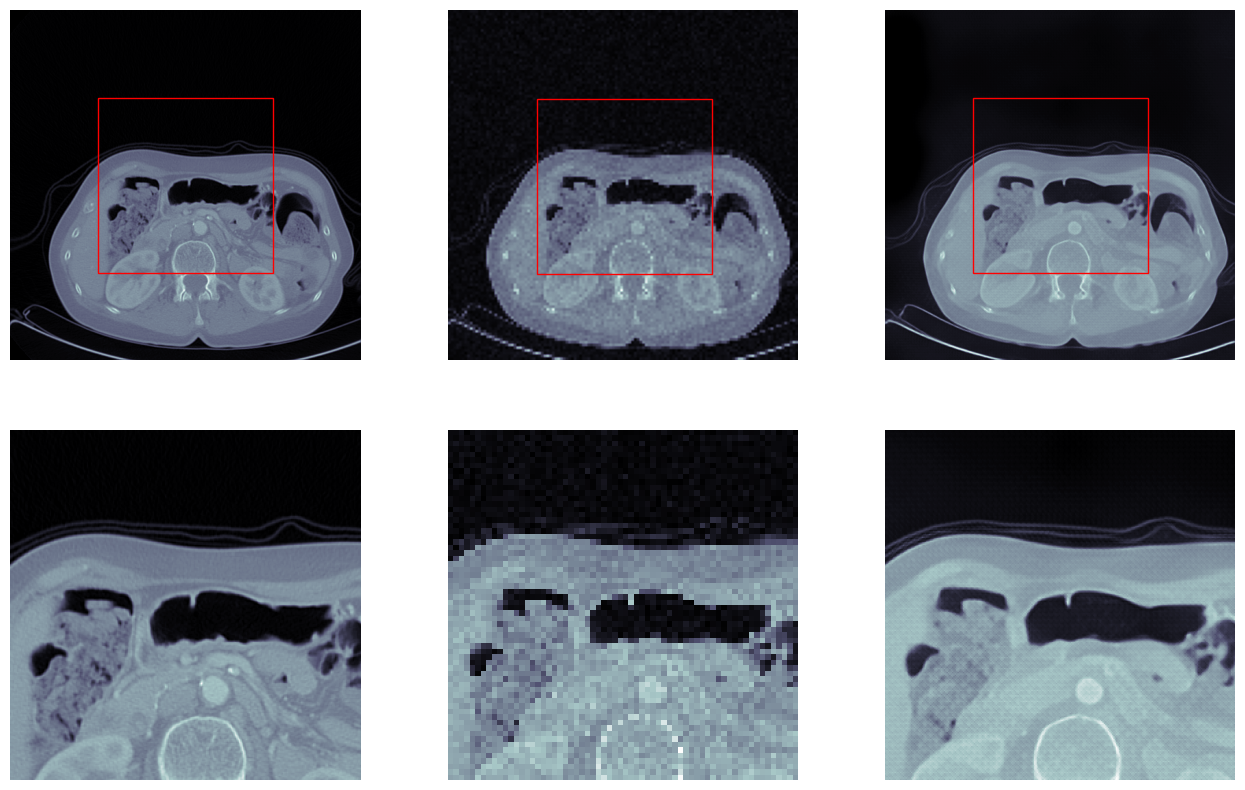

In [ ]:
print(psnr)
print(ssim)
fig, axess = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 10)
axess[0][0].imshow(imgs_hr, plt.cm.bone)
axess[0][0].set_axis_off()
axess[0][0].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][1].imshow(imgs_lr, plt.cm.bone)
axess[0][1].set_axis_off()
axess[0][1].add_patch(Rectangle((32, 32), 64, 64, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][2].imshow(gen_hr, plt.cm.bone)
axess[0][2].set_axis_off()
axess[0][2].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[1][0].imshow(imgs_hr[128:384, 128:384], plt.cm.bone)
axess[1][0].set_axis_off()
axess[1][1].imshow(imgs_lr[32:96, 32:96], plt.cm.bone)
axess[1][1].set_axis_off()
axess[1][2].imshow(gen_hr[128:384, 128:384], plt.cm.bone)
axess[1][2].set_axis_off()
plt.savefig('example.png', facecolor='white', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

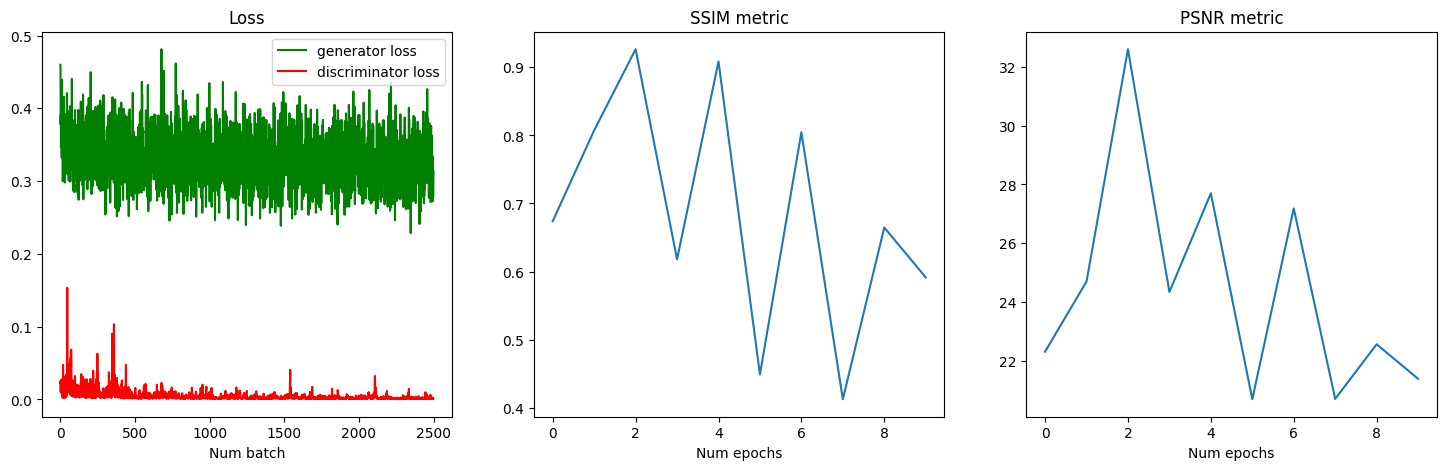

In [ ]:
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 5)
ax1.plot(batch_G_losses, color='g', label='generator loss')
ax1.plot(batch_D_losses, color='r', label='discriminator loss')
ax1.set_title('Loss')
ax1.set_xlabel('Num batch')
ax1.legend()
ax2.plot(eval_ssim_byepoch)
ax2.set_title('SSIM metric')
ax2.set_xlabel('Num epochs')
ax3.plot(eval_psnr_byepoch)
ax3.set_title('PSNR metric')
ax3.set_xlabel('Num epochs')
plt.savefig('plots.png', facecolor='white', bbox_inches='tight')
plt.show()